In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from tqdm import tqdm 
import datetime
from sympy import Integer

In [15]:
factor_path = "/Users/shezihua/Documents/MAFM/2022-2023 Summer/MAFS 6100L/SummerIndependentProject/factor/"

futureCodeList = ['JBF', 'QWF', 'HCF', 'DBF', 'EHF', 'IPF', 'IIF', 'QXF', 'PEF', 'NAF']
stockCodeList = ['3443', '2388', '2498', '2610', '1319', '3035', '3006', '2615', '5425', '3105']

data_clean_path = '/Users/shezihua/Documents/MAFM/2022-2023 Summer/MAFS 6100L/SummerIndependentProject/dataCleaned/'

JBF-3443 pairs begin


100%|██████████| 30/30 [02:25<00:00,  4.84s/it]

benchmark PnL


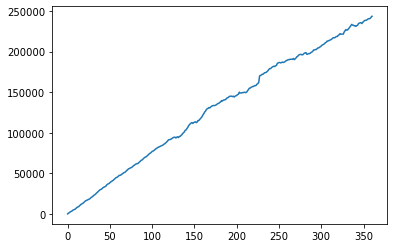

100%|██████████| 30/30 [02:25<00:00,  4.85s/it]

model PnL


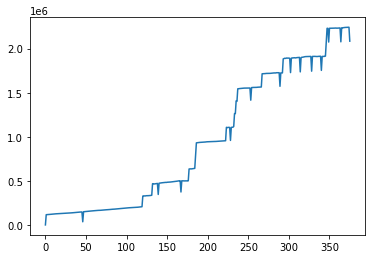

Two PnL


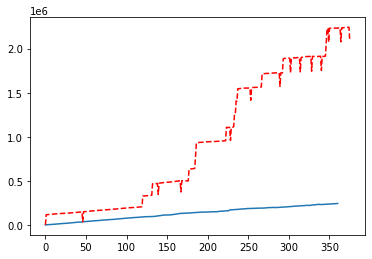

QWF-2388 pairs begin


100%|██████████| 30/30 [01:51<00:00,  3.71s/it]

benchmark PnL


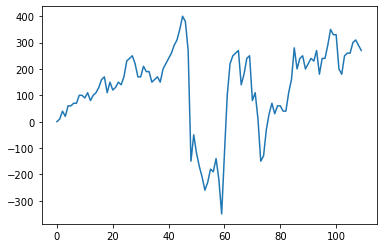

100%|██████████| 30/30 [01:51<00:00,  3.73s/it]

model PnL


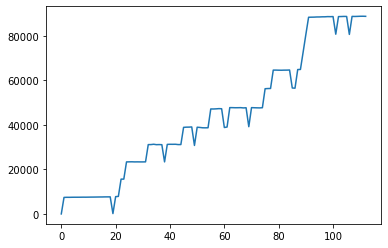

Two PnL


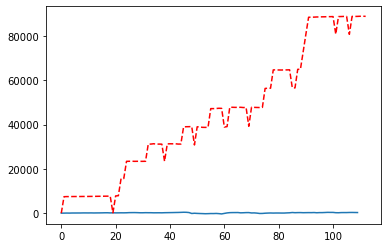

HCF-2498 pairs begin


100%|██████████| 30/30 [01:39<00:00,  3.31s/it]

benchmark PnL


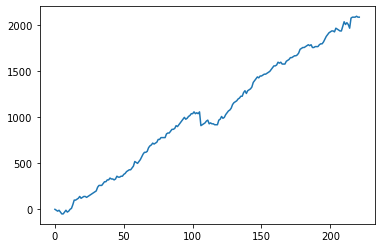

100%|██████████| 30/30 [01:40<00:00,  3.35s/it]

model PnL


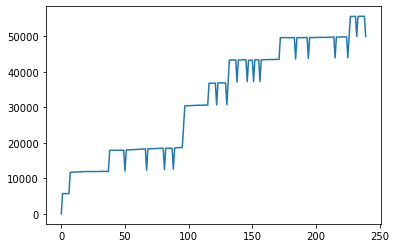

Two PnL


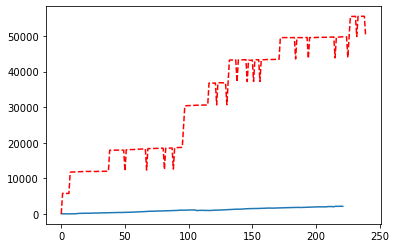

DBF-2610 pairs begin


100%|██████████| 30/30 [10:26<00:00, 20.88s/it]

benchmark PnL


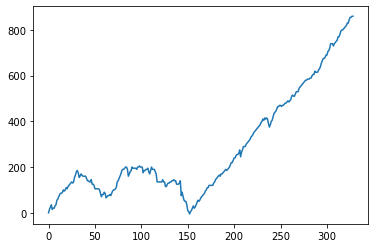

100%|██████████| 30/30 [10:24<00:00, 20.83s/it]

model PnL


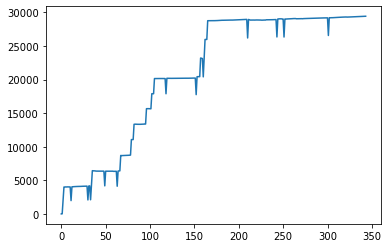

Two PnL


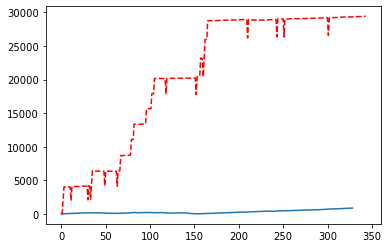

EHF-1319 pairs begin


100%|██████████| 30/30 [01:03<00:00,  2.11s/it]

benchmark PnL


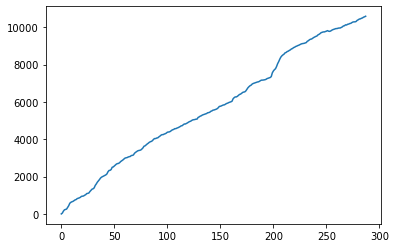

100%|██████████| 30/30 [01:03<00:00,  2.12s/it]

model PnL


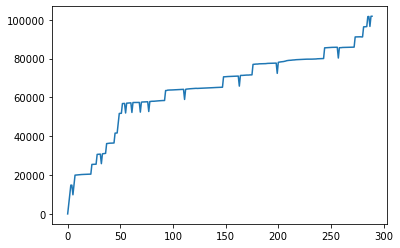

Two PnL


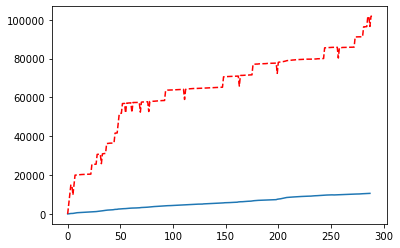

IPF-3035 pairs begin


100%|██████████| 30/30 [03:00<00:00,  6.03s/it]

benchmark PnL


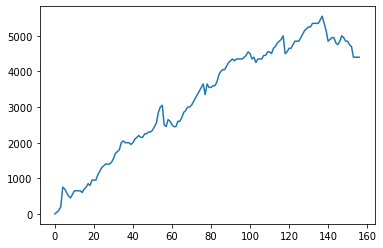

100%|██████████| 30/30 [03:00<00:00,  6.03s/it]

model PnL


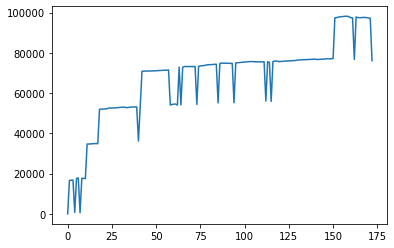

Two PnL


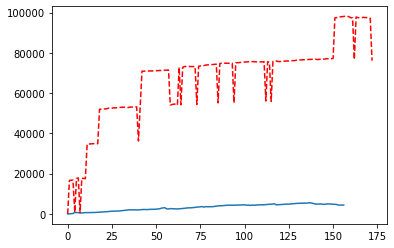

IIF-3006 pairs begin


100%|██████████| 30/30 [01:43<00:00,  3.44s/it]

benchmark PnL


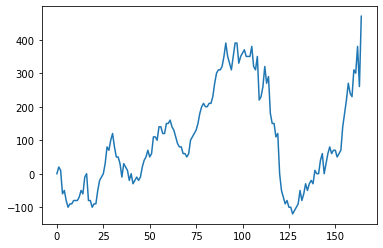

100%|██████████| 30/30 [01:43<00:00,  3.45s/it]

model PnL


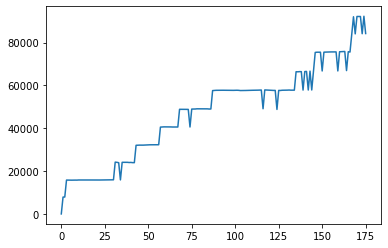

Two PnL


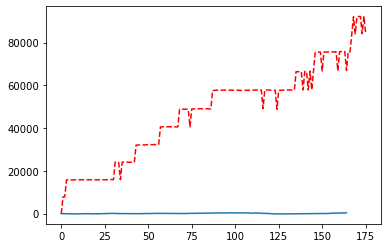

QXF-2615 pairs begin


100%|██████████| 30/30 [01:26<00:00,  2.89s/it]

benchmark PnL


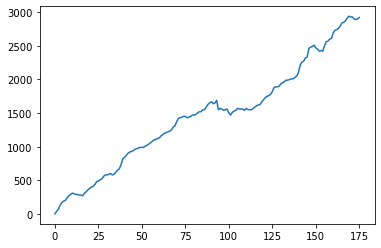

100%|██████████| 30/30 [01:27<00:00,  2.92s/it]

model PnL


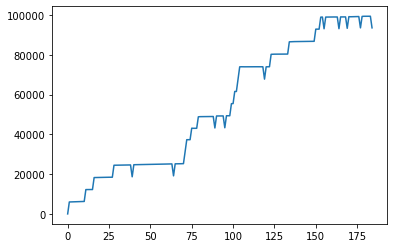

Two PnL


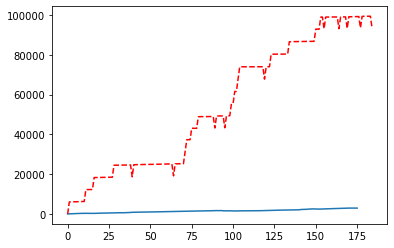

PEF-5425 pairs begin


100%|██████████| 30/30 [01:56<00:00,  3.88s/it]

benchmark PnL


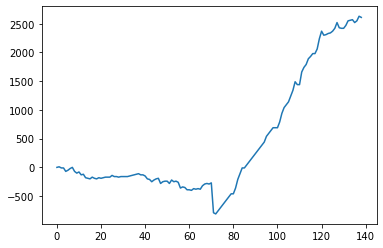

100%|██████████| 30/30 [01:57<00:00,  3.92s/it]

model PnL


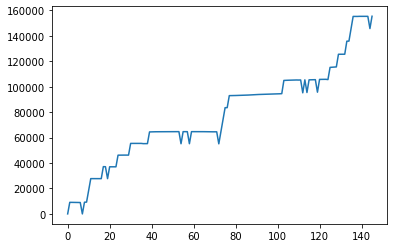

Two PnL


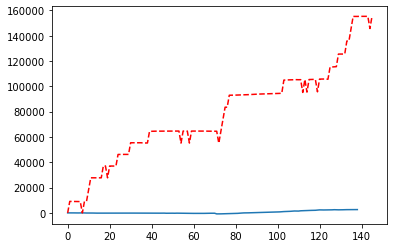

NAF-3105 pairs begin


100%|██████████| 30/30 [01:15<00:00,  2.53s/it]

benchmark PnL


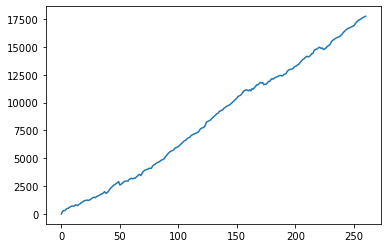

100%|██████████| 30/30 [01:16<00:00,  2.56s/it]

model PnL


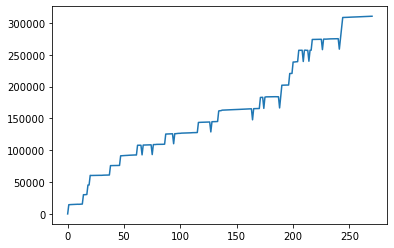

Two PnL


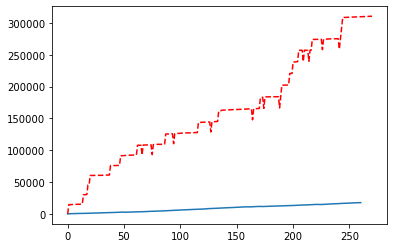

In [16]:
for code_idx in range(10):
    futureCode = futureCodeList[code_idx]
    stockCode = stockCodeList[code_idx]
    print("================================================")
    print(futureCode + '-' + stockCode + " pairs begin")

    stock = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/stock.csv.gz", compression='gzip', index_col=0)
    future = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/future.csv.gz", compression='gzip', index_col=0)
    spread = np.log(stock['price']) - np.log(future['midQ'])
    spread = pd.DataFrame(spread)
    spread.columns = ['spread']
    feature = pd.read_csv(factor_path + futureCode + "-" + stockCode + "/factor.csv.gz", compression='gzip', index_col=0)

    pool = pd.DataFrame()
    pool.index = stock.index
    pool['SP1'] = stock['SP1']
    pool['BP1'] = stock['BP1']
    pool['askPrice1'] = future['askPrice1']
    pool['bidPrice1'] = future['bidPrice1']
    pool['spread'] = spread['spread']
    pool.index = pd.to_datetime(pool.index)

    trade = pd.DataFrame()
    trade.index = pool.index
    trade['spread'] = pool['spread']
    trade['signal'] = 0
    trade['cap'] = 0
    trade['pnl'] = 0
    trade.index = pd.to_datetime(trade.index)


    # benchmark
    day_list = np.unique(pool.index.date)
    train_period = 3
    PnLb = np.array([0])

    for i in tqdm(range(len(day_list) - train_period)[-30:]):
        train_start_time = trade.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
        train_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
        train = trade[train_start_time & train_end_time]
        test_start_time = trade.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
        test_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
        test = trade[test_start_time & test_end_time]

        current_pool = pool[test_start_time & test_end_time]

        mean = np.mean(train['spread'])
        std = np.std(train['spread'])

        upper = mean + 1.5 * std
        lower = mean - 1.5 * std

        for tick_idx in (range(len(test.index))): 
            current_data = test[0:tick_idx + 1]

            if tick_idx != len(test.index) - 1:
                # long spread
                if test.loc[test.index[tick_idx]]['spread'] <= lower: 
                    if np.sum(current_data['signal']) == 0: 
                        test.at[test.index[tick_idx], 'signal'] = 1
                        test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']

                # back to mean
                elif test.loc[test.index[tick_idx]]['spread'] >= mean: 
                    if np.sum(current_data['signal']) == 1: 
                        test.at[test.index[tick_idx], 'signal'] = -1
                        test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                        test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']

                # short spread
                elif test.loc[test.index[tick_idx]]['spread'] >= upper: 
                    if np.sum(current_data['signal']) == 0: 
                        test.at[test.index[tick_idx], 'signal'] = -1
                        test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']

                # back to mean 
                elif test.loc[test.index[tick_idx]]['spread'] <= mean: 
                    if np.sum(current_data['signal']) == -1: 
                        test.at[test.index[tick_idx], 'signal'] = 1
                        test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                        test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']

                else: 
                    pass
            
            else:
                if np.sum(current_data['signal']) == 1: 
                    test.at[test.index[tick_idx], 'signal'] = -1
                    test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
                elif np.sum(current_data['signal']) == -1: 
                    test.at[test.index[tick_idx], 'signal'] = 1
                    test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
                else:
                    pass
        
        
        PnLb = np.append(PnLb, test[test['pnl'] != 0]['pnl'] + PnLb[-1])
    print("benchmark PnL")
    plt.plot(PnLb)
    plt.show()

    # model 
    pool = pd.DataFrame()
    pool.index = stock.index
    pool['SP1'] = stock['SP1']
    pool['BP1'] = stock['BP1']
    pool['askPrice1'] = future['askPrice1']
    pool['bidPrice1'] = future['bidPrice1']
    pool['spread'] = spread['spread']
    pool.index = pd.to_datetime(pool.index)

    trade = pd.DataFrame()
    trade.index = pool.index
    trade['spread'] = pool['spread']
    trade['signal'] = 0
    trade['cap'] = 0
    trade['pnl'] = 0
    trade.index = pd.to_datetime(trade.index)

    day_list = np.unique(pool.index.date)
    train_period = 3
    PnLm = np.array([0])

    for i in tqdm(range(len(day_list) - train_period)[-30:]):
        train_start_time = trade.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
        train_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
        train = trade[train_start_time & train_end_time]
        test_start_time = trade.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
        test_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
        test = trade[test_start_time & test_end_time]

        feature_train = feature[train_start_time & train_end_time]
        feature_test = feature[test_start_time & test_end_time]

        current_pool = pool[test_start_time & test_end_time]

        mean = np.mean(train['spread'])
        std = np.std(train['spread'])

        upper = mean + 1.5 * std
        lower = mean - 1.5 * std

        X_train = feature_train[feature_train.columns[0:-1]]
        y_train = feature_train['delta_spread']
        upper_quantile=0.85
        lower_quantile=0.15
        train_spread_upper = float(y_train.quantile(upper_quantile))
        train_spread_lower = float(y_train.quantile(lower_quantile))

        model_ols = LinearRegression()
        model_ols.fit(X_train, y_train)
        
        X_test = feature_test[feature_test.columns[0:-1]]
        y_test = feature_test['delta_spread']

        y_test_pred = model_ols.predict(X_test)

        for tick_idx in (range(len(test.index))): 
            current_data = test[0:tick_idx + 1]
            
            if tick_idx != len(test.index) - 1:
                # long spread
                if test.loc[test.index[tick_idx]]['spread'] <= lower: 
                    if np.sum(current_data['signal']) == 0: 
                        if y_test_pred[tick_idx] < train_spread_lower:
                            test.at[test.index[tick_idx+1], 'signal'] = 1
                            test.at[test.index[tick_idx+1], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                        else: 
                            test.at[test.index[tick_idx], 'signal'] = 1
                            test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']

                # back to mean
                elif test.loc[test.index[tick_idx]]['spread'] >= mean: 
                    if np.sum(current_data['signal']) == 1: 
                        if y_test_pred[tick_idx] > train_spread_upper:
                            test.at[test.index[tick_idx+1], 'signal'] = -1
                            test.at[test.index[tick_idx+1], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                            test.at[test.index[tick_idx+1], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
                        else:
                            test.at[test.index[tick_idx], 'signal'] = -1
                            test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                            test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']

                # short spread
                elif test.loc[test.index[tick_idx]]['spread'] >= upper: 
                    if np.sum(current_data['signal']) == 0: 
                        if y_test_pred[tick_idx] > train_spread_upper:
                            test.at[test.index[tick_idx+1], 'signal'] = -1
                            test.at[test.index[tick_idx+1], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                        else: 
                            test.at[test.index[tick_idx], 'signal'] = -1
                            test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']

                # back to mean 
                elif test.loc[test.index[tick_idx]]['spread'] <= mean: 
                    if np.sum(current_data['signal']) == -1: 
                        if y_test_pred[tick_idx] < train_spread_lower:
                            test.at[test.index[tick_idx+1], 'signal'] = 1
                            test.at[test.index[tick_idx+1], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                            test.at[test.index[tick_idx+1], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']
                        else: 
                            test.at[test.index[tick_idx], 'signal'] = 1
                            test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                            test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']

                else: 
                    pass
            
            else:
                pass
                if np.sum(current_data['signal']) == 1: 
                    test.at[test.index[tick_idx], 'signal'] = -1
                    test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
                elif np.sum(current_data['signal']) == -1: 
                    test.at[test.index[tick_idx], 'signal'] = 1
                    test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
                else:
                    pass
        
        
        PnLm = np.append(PnLm, test[test['pnl'] != 0]['pnl'] + PnLm[-1])
    print("model PnL")
    plt.plot(PnLm)
    plt.show()
    print("Two PnL")
    plt.plot(PnLb)
    plt.plot(PnLm, color='red', linestyle='--')
    plt.show()